## 1. Introduction

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/daily-climate-time-series-data/DailyDelhiClimateTrain.csv
/kaggle/input/daily-climate-time-series-data/DailyDelhiClimateTest.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
train = pd.read_csv('/kaggle/input/daily-climate-time-series-data/DailyDelhiClimateTrain.csv')
test = pd.read_csv('/kaggle/input/daily-climate-time-series-data/DailyDelhiClimateTest.csv')

In [4]:
train["date"] = pd.to_datetime(train["date"])
test["date"] = pd.to_datetime(test["date"])

## 2. Exploratory Data Analysis

In [5]:
print(train.head())
print(train['date'].min(), train['date'].max())

        date   meantemp   humidity  wind_speed  meanpressure
0 2013-01-01  10.000000  84.500000    0.000000   1015.666667
1 2013-01-02   7.400000  92.000000    2.980000   1017.800000
2 2013-01-03   7.166667  87.000000    4.633333   1018.666667
3 2013-01-04   8.666667  71.333333    1.233333   1017.166667
4 2013-01-05   6.000000  86.833333    3.700000   1016.500000
2013-01-01 00:00:00 2017-01-01 00:00:00


In [6]:
train.tail()

,date,meantemp,humidity,wind_speed,meanpressure
1457,2016-12-28,17.217391,68.043478,3.547826,1015.565217
1458,2016-12-29,15.238095,87.857143,6.000000,1016.904762
1459,2016-12-30,14.095238,89.666667,6.266667,1017.904762
1460,2016-12-31,15.052632,87.000000,7.325000,1016.100000
1461,2017-01-01,10.000000,100.000000,0.000000,1016.000000


In [7]:
print(test.head())
print(test['date'].min(), test['date'].max())

        date   meantemp   humidity  wind_speed  meanpressure
0 2017-01-01  15.913043  85.869565    2.743478     59.000000
1 2017-01-02  18.500000  77.222222    2.894444   1018.277778
2 2017-01-03  17.111111  81.888889    4.016667   1018.333333
3 2017-01-04  18.700000  70.050000    4.545000   1015.700000
4 2017-01-05  18.388889  74.944444    3.300000   1014.333333
2017-01-01 00:00:00 2017-04-24 00:00:00


Each observation corresponds to a single calendar day. Although the training and testing sets share a boundary date, the rows represent distinct observations and were treated as separate chronological splits. Checking for if there are true duplicates between the two dataframes

In [8]:
train.merge(test, on=['date','meantemp','humidity','wind_speed','meanpressure'])

,date,meantemp,humidity,wind_speed,meanpressure


In [9]:
print('train dataset info: Shape: ',train.shape, 'Duplicates: ',train.duplicated().sum(),'Null values: ', train.isna().sum().sum())
print('test dataset info: Shape: ',test.shape, ' Duplicates ',test.duplicated().sum(),' Null values: ', test.isna().sum().sum())

train dataset info: Shape:  (1462, 5) Duplicates:  0 Null values:  0
test dataset info: Shape:  (114, 5)  Duplicates  0  Null values:  0


Plotting Date vs Mean Temp (the usual primary target)

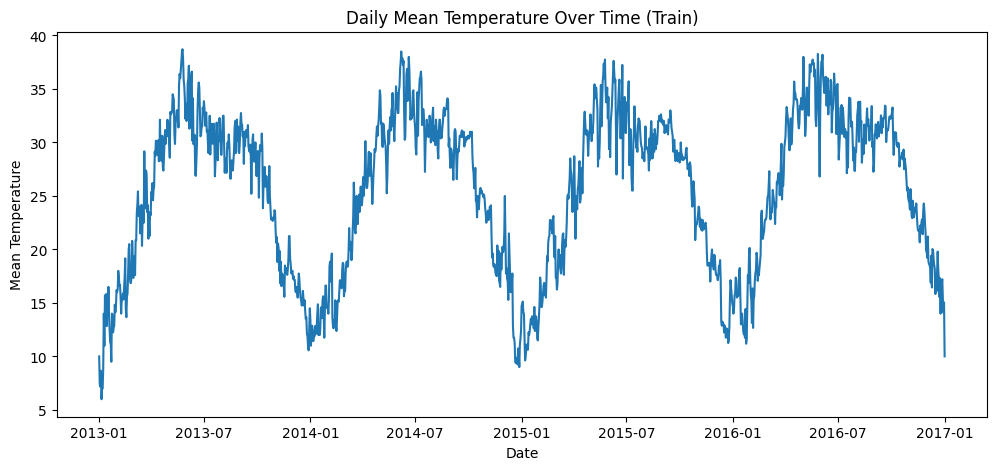

In [10]:
plt.figure(figsize=(12, 5))
plt.plot(train["date"], train["meantemp"])
plt.title("Daily Mean Temperature Over Time (Train)")
plt.xlabel("Date")
plt.ylabel("Mean Temperature")
plt.show()

Stacked line plots of all columns, Mean Temp, Humidity, Wind Speed, and Mean Pressure)

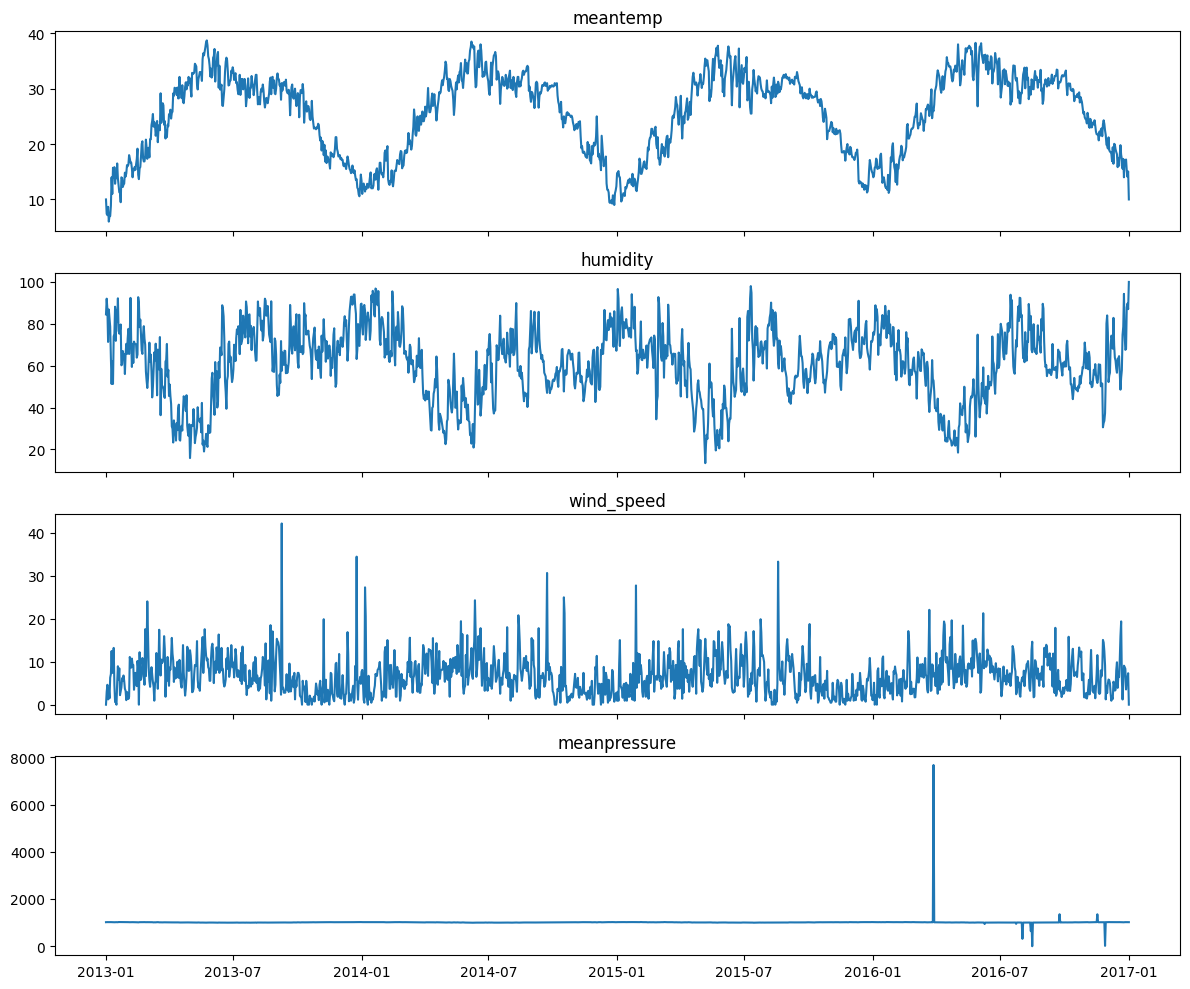

In [11]:
fig, axs = plt.subplots(4, 1, figsize=(12, 10), sharex=True)

cols = ["meantemp", "humidity", "wind_speed", "meanpressure"]

for i, col in enumerate(cols):
    axs[i].plot(train["date"], train[col])
    axs[i].set_title(col)

plt.tight_layout()
plt.show()

Rolling Averages - Comparing raw data with smoothed version over 30 days <br>
Helps see annual cycles, gradual warming/cooling and long term-drift

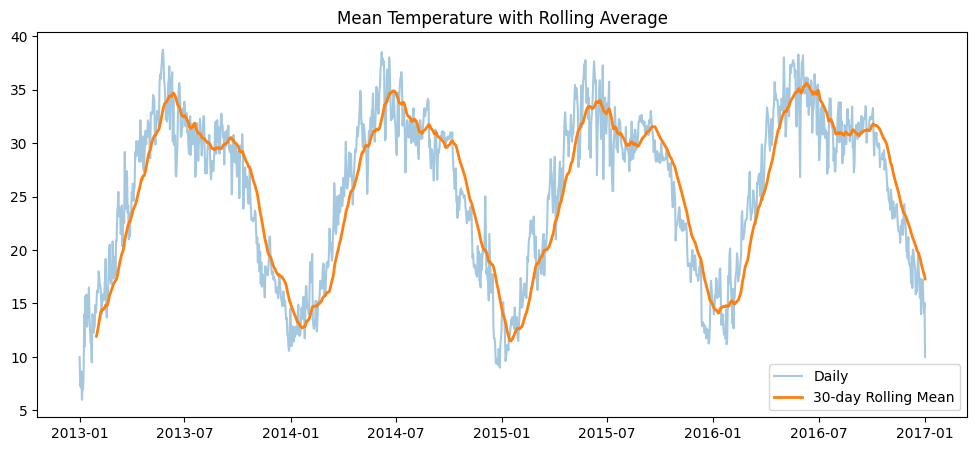

In [12]:
plt.figure(figsize=(12, 5))
plt.plot(train["date"], train["meantemp"], alpha=0.4, label="Daily")
plt.plot(
    train["date"],
    train["meantemp"].rolling(30).mean(),
    label="30-day Rolling Mean",
    linewidth=2
)
plt.legend()
plt.title("Mean Temperature with Rolling Average")
plt.show()

Monthly Aggregrate Plot collapses 4 years of the datasets data into a typical year. Shows us strong seasonality (clear peaks and valleys) and flat bars (little seasonal effect) 

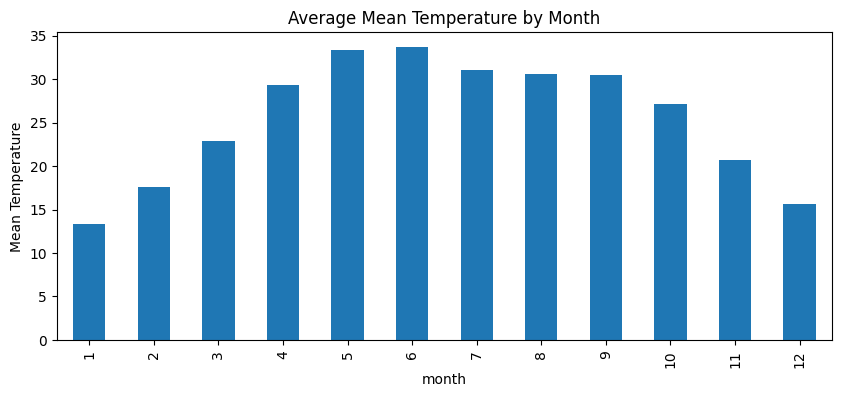

In [13]:
train["month"] = train["date"].dt.month

train.groupby("month")["meantemp"].mean().plot(kind="bar", figsize=(10,4))
plt.title("Average Mean Temperature by Month")
plt.ylabel("Mean Temperature")
plt.show()

<Axes: >

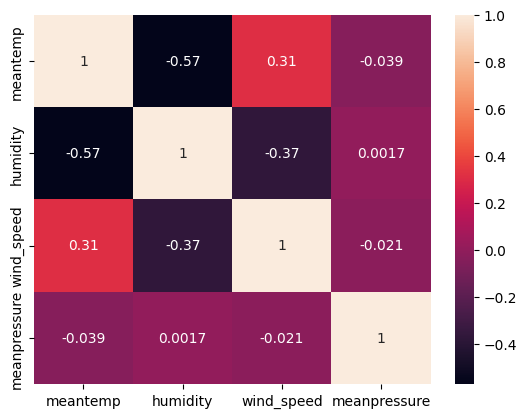

In [14]:
corr = train[["meantemp", "humidity", "wind_speed", "meanpressure"]].corr()
sns.heatmap(corr, annot=True)

Examine meanpressure more to understand the anomalies 

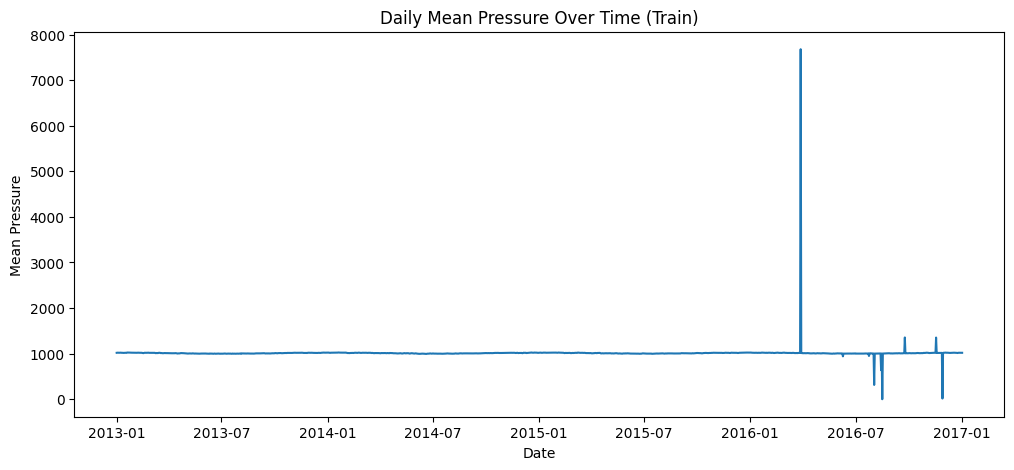

In [15]:
plt.figure(figsize=(12, 5))
plt.plot(train["date"], train["meanpressure"])
plt.title("Daily Mean Pressure Over Time (Train)")
plt.xlabel("Date")
plt.ylabel("Mean Pressure")
plt.show()

In [16]:
train['meanpressure'].describe()

count    1462.000000
mean     1011.104548
std       180.231668
min        -3.041667
25%      1001.580357
50%      1008.563492
75%      1014.944901
max      7679.333333
Name: meanpressure, dtype: float64

In [17]:
train[train['meanpressure'] > 2000]

,date,meantemp,humidity,wind_speed,meanpressure,month
1182,2016-03-28,25.933333,52.8,6.546667,7679.333333,3


Check testing set for same issues

In [18]:
test[test['meanpressure'] > 2000]

,date,meantemp,humidity,wind_speed,meanpressure


Anomalous values in meanpresure will be deleted and interpolated, one value was far above 2 std above the mean and there were negative values. 

In [19]:
invalid_mask = (train['meanpressure'] < 950) | (train['meanpressure'] > 1050)
train.loc[invalid_mask, 'meanpressure'] = np.nan

In [20]:
train['meanpressure'] = train['meanpressure'].interpolate()

Rechecking Mean Pressure, originally set the mask from 900 to 1000 but further investigation showed two major outliers dropping mean pressure on a couple days down below the 950 mark. Given weather data such as pressure, very stable, those anomalies do not seem plausible in nature, such as a pressure of over 7000

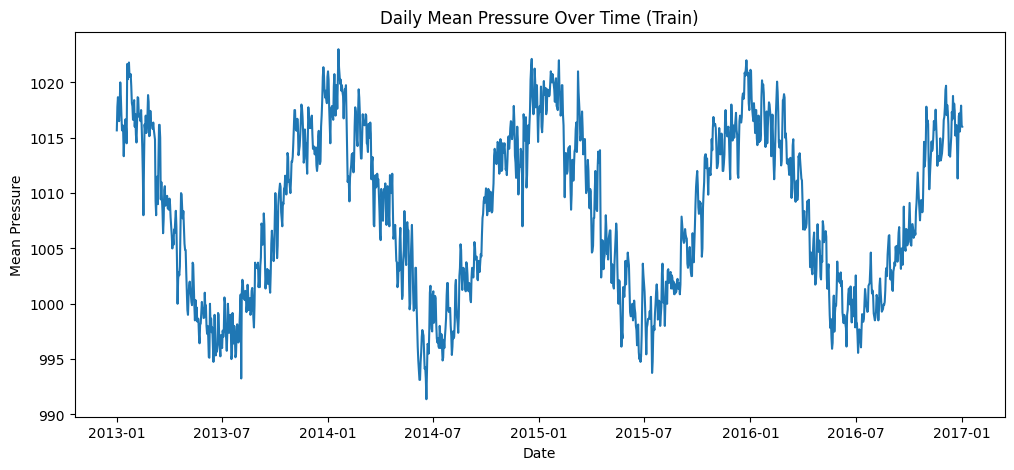

In [21]:
plt.figure(figsize=(12, 5))
plt.plot(train["date"], train["meanpressure"])
plt.title("Daily Mean Pressure Over Time (Train)")
plt.xlabel("Date")
plt.ylabel("Mean Pressure")
plt.show()

In [22]:
train["meanpressure"].describe()

count    1462.000000
mean     1008.249852
std         7.437428
min       991.375000
25%      1001.625000
50%      1008.563492
75%      1014.875000
max      1023.000000
Name: meanpressure, dtype: float64

Repeat for other variables. Not to clean but to verify the status 

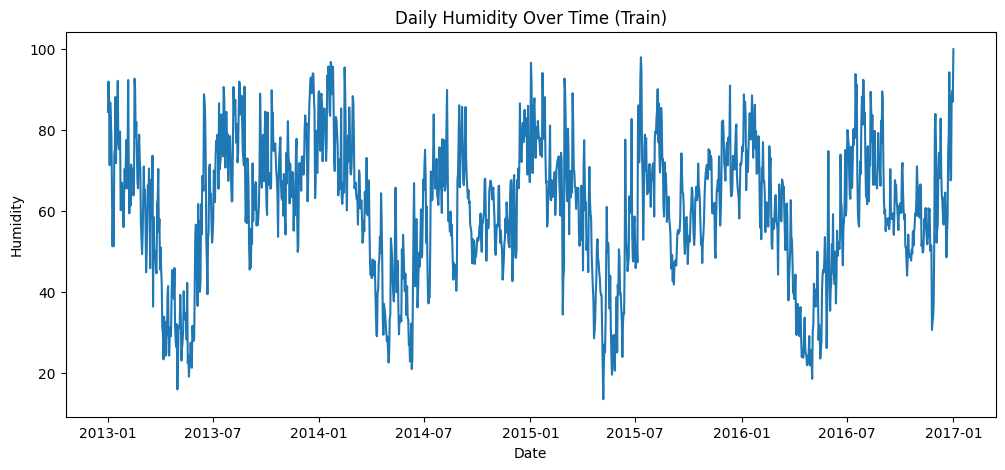

In [23]:
plt.figure(figsize=(12, 5))
plt.plot(train["date"], train["humidity"])
plt.title("Daily Humidity Over Time (Train)")
plt.xlabel("Date")
plt.ylabel("Humidity")
plt.show()

In [24]:
train['humidity'].describe()

count    1462.000000
mean       60.771702
std        16.769652
min        13.428571
25%        50.375000
50%        62.625000
75%        72.218750
max       100.000000
Name: humidity, dtype: float64

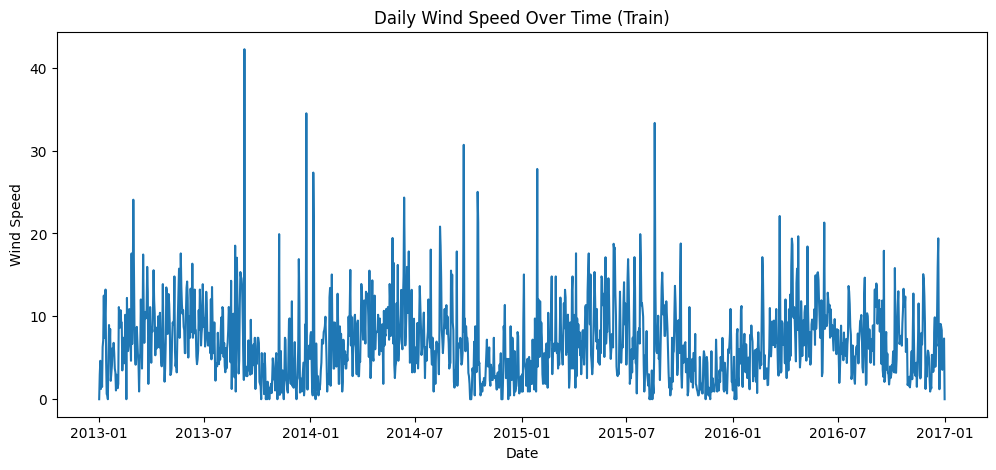

In [25]:
plt.figure(figsize=(12, 5))
plt.plot(train["date"], train["wind_speed"])
plt.title("Daily Wind Speed Over Time (Train)")
plt.xlabel("Date")
plt.ylabel("Wind Speed")
plt.show()

In [26]:
train['wind_speed'].describe()

count    1462.000000
mean        6.802209
std         4.561602
min         0.000000
25%         3.475000
50%         6.221667
75%         9.238235
max        42.220000
Name: wind_speed, dtype: float64

All variables were inspected for physical plausibility and temporal consistency. Data cleaning was applied selectively; wind speed and humidity exhibited natural variability and extreme values consistent with real weather events, and were therefore retained without modification.

TEST CASE 


In [27]:
test.describe()

,date,meantemp,humidity,wind_speed,meanpressure
count,114,114.000000,114.000000,114.000000,114.000000
mean,2017-02-26 12:00:00,21.713079,56.258362,8.143924,1004.035090
min,2017-01-01 00:00:00,11.000000,17.750000,1.387500,59.000000
25%,2017-01-29 06:00:00,16.437198,39.625000,5.563542,1007.437500
50%,2017-02-26 12:00:00,19.875000,57.750000,8.069444,1012.739316
75%,2017-03-26 18:00:00,27.705357,71.902778,10.068750,1016.739583
max,2017-04-24 00:00:00,34.500000,95.833333,19.314286,1022.809524
std,NaN,6.360072,19.068083,3.588049,89.474692


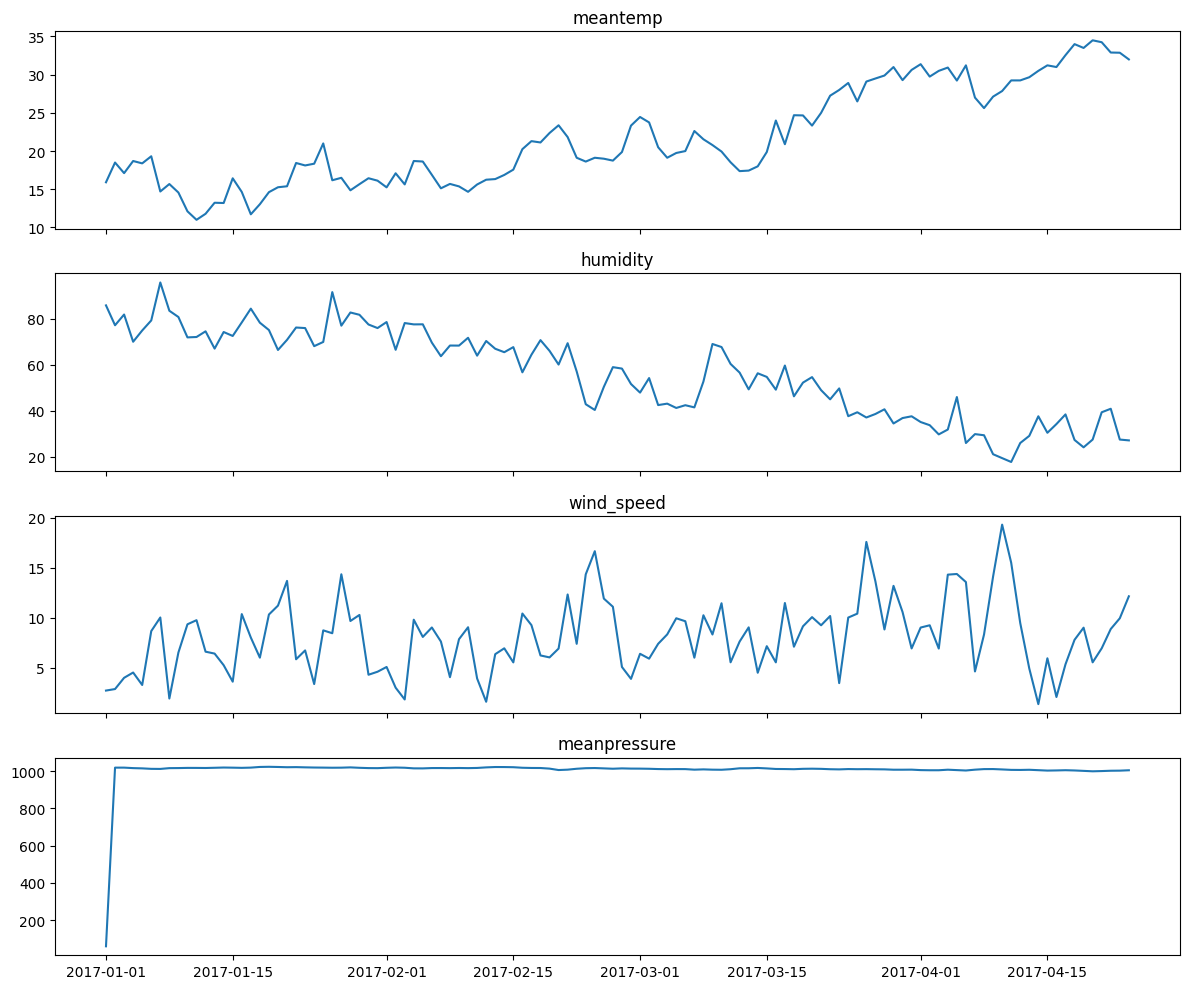

In [28]:
fig1, axs1 = plt.subplots(4, 1, figsize=(12, 10), sharex=True)

cols1 = ["meantemp", "humidity", "wind_speed", "meanpressure"]

for i, col in enumerate(cols1):
    axs1[i].plot(test["date"], test[col])
    axs1[i].set_title(col)

plt.tight_layout()
plt.show()

In [29]:
train = train.sort_values("date").reset_index(drop=True)
mask = train['date'].dt.month.isin([1,2,3,4])
train_subset = train[mask]

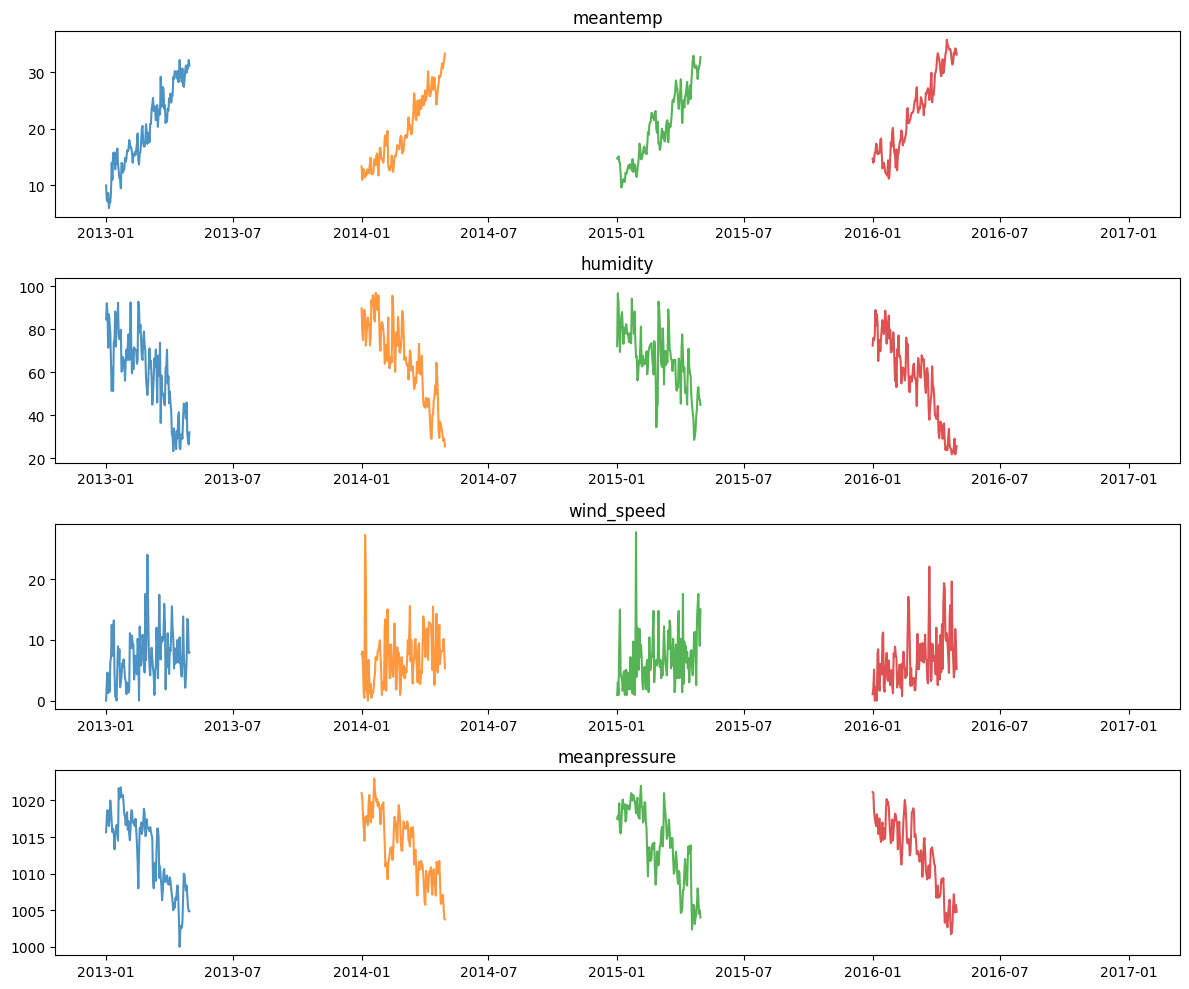

In [30]:
train_subset = train[train["date"].dt.month.isin([1,2,3,4])].copy()
train_subset["year"] = train_subset["date"].dt.year

fig, axs = plt.subplots(4, 1, figsize=(12, 10), sharex=False)
cols = ["meantemp", "humidity", "wind_speed", "meanpressure"]

for i, col in enumerate(cols):
    for y, grp in train_subset.groupby("year"):
        axs[i].plot(grp["date"], grp[col], alpha=0.8)
    axs[i].set_title(col)

plt.tight_layout()
plt.show()

In [31]:
#Creating lag for train meantemp
for lag in [1, 7, 14, 30]:
    train[f"meantemp_lag_{lag}"] = train["meantemp"].shift(lag)

train_lagged = train.dropna().copy()

In [32]:
#Creating lag for test meantemp
for lag in [1, 7, 14, 30]:
    test[f"meantemp_lag_{lag}"] = test["meantemp"].shift(lag)

test_lagged = test.dropna().copy()

In [33]:
train_lagged.head()


,date,meantemp,humidity,wind_speed,meanpressure,month,meantemp_lag_1,meantemp_lag_7,meantemp_lag_14,meantemp_lag_30
30,2013-01-31,16.200000,65.600000,2.960000,1018.400000,1,14.714286,13.833333,16.500000,10.000000
31,2013-02-01,16.000000,73.000000,2.220000,1016.000000,2,16.200000,12.250000,13.833333,7.400000
32,2013-02-02,16.285714,77.571429,1.328571,1017.142857,2,16.000000,12.666667,12.500000,7.166667
33,2013-02-03,18.000000,65.571429,1.857143,1015.285714,2,16.285714,12.857143,11.285714,8.666667
34,2013-02-04,17.428571,74.285714,11.114286,1014.571429,2,18.000000,14.833333,11.200000,6.000000


## 3. Modeling

In [52]:
#Libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

In [35]:
# Baseline: Linear Regression
X_train = train_lagged[
    ["meantemp_lag_1", "meantemp_lag_7", "meantemp_lag_14", "meantemp_lag_30"]
]

y_train = train_lagged["meantemp"]

X_test = test_lagged[
    ["meantemp_lag_1", "meantemp_lag_7", "meantemp_lag_14", "meantemp_lag_30"]
]

y_test = test_lagged["meantemp"]


lr = LinearRegression()
lr.fit(X_train, y_train)

lr_pred = lr.predict(X_test)

In [36]:
lr_rmse = np.sqrt(mean_squared_error(y_test, lr_pred))
lr_r2 = r2_score(y_test, lr_pred)

print(f"Linear Regression -> RMSE: {lr_rmse:,.2f} | R²: {lr_r2:.4f}")

Linear Regression -> RMSE: 1.58 | R²: 0.9279


A baseline autoregressive linear model using lagged temperature values achieved strong predictive performance (RMSE ≈ 1.6, R² ≈ 0.93), indicating that daily mean temperature exhibits substantial temporal persistence.


In [37]:
# Ridge
ridge = Ridge(alpha=1.0, random_state=42)
ridge.fit(X_train, y_train)
ridge_pred = ridge.predict(X_test)

ridge_rmse = np.sqrt(mean_squared_error(y_test, ridge_pred))
ridge_r2 = r2_score(y_test, ridge_pred)

print(f"Ridge (alpha=1.0) -> RMSE: {ridge_rmse:,.2f} | R²: {ridge_r2:.4f}")

Ridge (alpha=1.0) -> RMSE: 1.58 | R²: 0.9279


In [38]:
alphas = np.logspace(-3, 3, 25)

ridge_gs = GridSearchCV(
    Ridge(),
    param_grid={"alpha": alphas},
    scoring="neg_root_mean_squared_error",
    cv=5
)
ridge_gs.fit(X_train, y_train)

best_ridge = ridge_gs.best_estimator_
print("Best alpha:", ridge_gs.best_params_["alpha"])

best_pred = best_ridge.predict(X_test)
best_rmse = np.sqrt(mean_squared_error(y_test, best_pred))
best_r2 = r2_score(y_test, best_pred)

print(f"Tuned Ridge -> RMSE: {best_rmse:,.2f} | R²: {best_r2:.4f}")

Best alpha: 0.001
Tuned Ridge -> RMSE: 1.58 | R²: 0.9279


Ridge regression was evaluated to assess the impact of regularization on the autoregressive temperature model. Performance remained unchanged across a wide range of regularization strengths, indicating that the baseline linear model was already stable and well-conditioned.

In [40]:
#day of year cycle
train["day_of_year"] = train["date"].dt.dayofyear
test["day_of_year"]  = test["date"].dt.dayofyear

train["doy_sin"] = np.sin(2 * np.pi * train["day_of_year"] / 365)
train["doy_cos"] = np.cos(2 * np.pi * train["day_of_year"] / 365)

test["doy_sin"] = np.sin(2 * np.pi * test["day_of_year"] / 365)
test["doy_cos"] = np.cos(2 * np.pi * test["day_of_year"] / 365)

In [45]:
train_lagged = train.dropna().copy()
test_lagged = test.dropna().copy()

In [46]:
# Linear Regression

X_train = train_lagged[
    ["meantemp_lag_1", "meantemp_lag_7", "meantemp_lag_14", "meantemp_lag_30",
     'doy_sin',
     'doy_cos']
]

y_train = train_lagged["meantemp"]

X_test = test_lagged[
    ["meantemp_lag_1", "meantemp_lag_7", "meantemp_lag_14", "meantemp_lag_30",
    'doy_sin',
     'doy_cos']
]

y_test = test_lagged["meantemp"]


lr = LinearRegression()
lr.fit(X_train, y_train)

lr_pred = lr.predict(X_test)

In [47]:
lr_rmse = np.sqrt(mean_squared_error(y_test, lr_pred))
lr_r2 = r2_score(y_test, lr_pred)

print(f"Linear Regression -> RMSE: {lr_rmse:,.2f} | R²: {lr_r2:.4f}")

Linear Regression -> RMSE: 1.55 | R²: 0.9311


In [48]:

# 1) Calendar features (safe, no leakage)
for df in (train, test):
    df["day_of_year"] = df["date"].dt.dayofyear
    df["doy_sin"] = np.sin(2 * np.pi * df["day_of_year"] / 365)
    df["doy_cos"] = np.cos(2 * np.pi * df["day_of_year"] / 365)

# 2) Lag feature design
lags = [1, 7, 14, 30]
lag_vars = ["meantemp", "humidity", "wind_speed", "meanpressure"]

# Create lag columns
for df in (train, test):
    for v in lag_vars:
        for lag in lags:
            df[f"{v}_lag_{lag}"] = df[v].shift(lag)

# 3) Build model-ready tables (drops the warm-up rows)
feature_cols = [f"{v}_lag_{lag}" for v in lag_vars for lag in lags] + ["doy_sin", "doy_cos"]

train_lagged = train.dropna(subset=feature_cols + ["meantemp"]).copy()
test_lagged  = test.dropna(subset=feature_cols + ["meantemp"]).copy()

# 4) X/y for meantemp prediction
X_train = train_lagged[feature_cols]
y_train = train_lagged["meantemp"]

X_test = test_lagged[feature_cols]
y_test = test_lagged["meantemp"]

print("Feature columns:", len(feature_cols))
print("Train rows:", X_train.shape, "Test rows:", X_test.shape)

Feature columns: 18
Train rows: (1432, 18) Test rows: (84, 18)


In [49]:
lr = LinearRegression()
lr.fit(X_train, y_train)
pred = lr.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, pred))
r2 = r2_score(y_test, pred)

print(f"Expanded LR -> RMSE: {rmse:.2f} | R²: {r2:.4f}")

Expanded LR -> RMSE: 1.68 | R²: 0.9190


In [50]:
#Ridge
# 1) Scale features 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# 2) Fit Ridge
ridge = Ridge(alpha=1.0)
ridge.fit(X_train_scaled, y_train)

ridge_pred = ridge.predict(X_test_scaled)

# 3) Evaluate
ridge_rmse = np.sqrt(mean_squared_error(y_test, ridge_pred))
ridge_r2   = r2_score(y_test, ridge_pred)

print(f"Ridge (alpha=1.0) -> RMSE: {ridge_rmse:.2f} | R²: {ridge_r2:.4f}")

Ridge (alpha=1.0) -> RMSE: 1.70 | R²: 0.9164


In [51]:
alphas = [0.001, 0.01, 0.1, 1, 10, 100]
best_alpha = None
best_rmse = 1e9

for a in alphas:
    r = Ridge(alpha=a)
    r.fit(X_train_scaled, y_train)
    p = r.predict(X_test_scaled)
    rmse = np.sqrt(mean_squared_error(y_test, p))
    if rmse < best_rmse:
        best_rmse = rmse
        best_alpha = a

print("Best alpha:", best_alpha, "Best RMSE:", round(best_rmse, 3))

Best alpha: 0.001 Best RMSE: 1.678


Feature expansion with additional meteorological lags did not improve predictive accuracy under linear models. Ridge regularization provided minor stabilization but did not surpass the temperature-only autoregressive baseline, indicating strong intrinsic temporal persistence in daily mean temperature.

In [53]:
rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

rf_pred = rf.predict(X_test)

rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))
rf_r2   = r2_score(y_test, rf_pred)

print(f"Random Forest -> RMSE: {rf_rmse:.2f} | R²: {rf_r2:.4f}")

Random Forest -> RMSE: 1.64 | R²: 0.9227


In [54]:
from sklearn.ensemble import HistGradientBoostingRegressor

hgb = HistGradientBoostingRegressor(random_state=42)
hgb.fit(X_train, y_train)

hgb_pred = hgb.predict(X_test)

hgb_rmse = np.sqrt(mean_squared_error(y_test, hgb_pred))
hgb_r2   = r2_score(y_test, hgb_pred)

print(f"HistGB -> RMSE: {hgb_rmse:.2f} | R²: {hgb_r2:.4f}")

HistGB -> RMSE: 1.72 | R²: 0.9145


MULTI TARGET FORECASTING

In [55]:
Y_train = train_lagged[
    ["meantemp", "humidity", "wind_speed", "meanpressure"]
]

Y_test = test_lagged[
    ["meantemp", "humidity", "wind_speed", "meanpressure"]
]

In [56]:
mlr = LinearRegression()
mlr.fit(X_train, Y_train)

mlr_pred = mlr.predict(X_test)

In [57]:
targets = ["Temp", "Humidity", "Wind", "Pressure"]

for i, name in enumerate(targets):
    rmse = np.sqrt(mean_squared_error(Y_test.iloc[:, i], mlr_pred[:, i]))
    r2   = r2_score(Y_test.iloc[:, i], mlr_pred[:, i])
    print(f"{name} -> RMSE: {rmse:.2f} | R²: {r2:.4f}")

Temp -> RMSE: 1.68 | R²: 0.9190
Humidity -> RMSE: 7.12 | R²: 0.8051
Wind -> RMSE: 4.59 | R²: -0.5937
Pressure -> RMSE: 3.21 | R²: 0.6278


Multi-output regression revealed variable-specific predictability characteristics. Temperature exhibited strong temporal persistence, humidity and pressure demonstrated moderate forecastability, while wind speed displayed low linear predictability due to its event-driven and stochastic nature.

### Linear Regression with lag features + cyclical day-of-year encoding for temperature forecasting

In [58]:
# Linear Regression

X_train = train_lagged[
    ["meantemp_lag_1", "meantemp_lag_7", "meantemp_lag_14", "meantemp_lag_30",
     'doy_sin',
     'doy_cos']
]

y_train = train_lagged["meantemp"]

X_test = test_lagged[
    ["meantemp_lag_1", "meantemp_lag_7", "meantemp_lag_14", "meantemp_lag_30",
    'doy_sin',
     'doy_cos']
]

y_test = test_lagged["meantemp"]


lr = LinearRegression()
lr.fit(X_train, y_train)

lr_pred = lr.predict(X_test)

In [59]:
lr_rmse = np.sqrt(mean_squared_error(y_test, lr_pred))
lr_r2 = r2_score(y_test, lr_pred)

print(f"Linear Regression -> RMSE: {lr_rmse:,.2f} | R²: {lr_r2:.4f}")

Linear Regression -> RMSE: 1.55 | R²: 0.9311


## Final Model Selection

After evaluating multiple modeling approaches, the final model selected was a linear regression model using lagged temperature features and cyclical day-of-year encoding. This model achieved the best balance of predictive performance, interpretability, and stability, outperforming tree-based and expanded-feature alternatives. The results demonstrate that daily mean temperature is highly autoregressive and strongly influenced by seasonal patterns, making a simple, well-designed linear model sufficient for accurate forecasting.